In [1]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

2022-04-21 13:36:49.064007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 13:36:49.064092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

Loading Datasets

In [3]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
#print(type(X_train))
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)
print( np.array(X_train).shape)

(200, 2)


/tmp/ipykernel_197/2653731770.py:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print( np.array(X_train).shape)
/tmp/ipykernel_197/2653731770.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print( np.array(X_train).shape)


In [4]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)
np.array(X_test).shape

/tmp/ipykernel_197/4080750455.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(X_test).shape
/tmp/ipykernel_197/4080750455.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(X_test).shape


(100, 2)

### Initializing classes for Quantum MLP

In [5]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [6]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.52


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [7]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

### MNIST DATASET

In [8]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [38]:
for batch_idx, (data, target) in enumerate(train_loader):
    print("Batch: ",batch_idx)
    print("Data| ",data.shape)
    print("Target| ",target.shape)

Batch:  0
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  1
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  2
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  3
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  4
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  5
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  6
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  7
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  8
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  9
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  10
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  11
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  12
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  13
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  14
Data|  torch.Size([

Batch:  142
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  143
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  144
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  145
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  146
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  147
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  148
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  149
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  150
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  151
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  152
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  153
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  154
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:  155
Data|  torch.Size([1, 1, 28, 28])
Target|  torch.Size([1])
Batch:

In [10]:
model = Net_MNIST()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(target)
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/tmp/ipykernel_197/2571825612.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  result = torch.tensor([expectation_z])
/tmp/ipykernel_197/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8031
Training [10%]	Loss: -0.9234
Training [15%]	Loss: -0.9399
Training [20%]	Loss: -0.9452
Training [25%]	Loss: -0.9523
Training [30%]	Loss: -0.9600
Training [35%]	Loss: -0.9603
Training [40%]	Loss: -0.9659
Training [45%]	Loss: -0.9544
Training [50%]	Loss: -0.9630
Training [55%]	Loss: -0.9717
Training [60%]	Loss: -0.9759
Training [65%]	Loss: -0.9803
Training [70%]	Loss: -0.9759
Training [75%]	Loss: -0.9818
Training [80%]	Loss: -0.9870
Training [85%]	Loss: -0.9899
Training [90%]	Loss: -0.9896
Training [95%]	Loss: -0.9879
Training [100%]	Loss: -0.9910


In [11]:
def eval_Arb(model,test_loader, loss_function):
    model.eval()
    with torch.no_grad():

        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)

            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
            sum(total_loss) / len(total_loss),
            correct / len(test_loader) * 100)
            )

In [12]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.9912
	Accuracy: 100.0%


Text(0, 0.5, 'Neg Log Likelihood Loss')

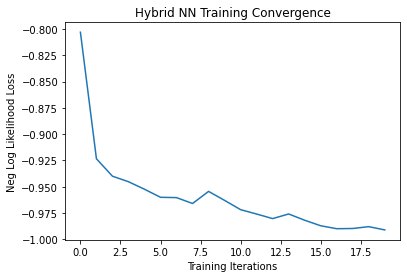

In [13]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

## OG DATASET
#### Loaded Dataset

In [63]:

# Direct Kernel Set Training Data
dks_train_1 = pd.read_csv('data/Direct_Kernel_Set_I_Training.csv')

# Direct Kernel Set Classifcation Data
dks_class_1 = pd.read_csv('data/Direct_Kernel_Set_I_Classifications.csv')

x1_train = dks_class_1.iloc[:, 1:3]
y1_train = dks_class_1.iloc[:, 3]
x1_test = dks_train_1.iloc[:, 1:3]
y1_test = dks_train_1.iloc[:, 3]

"""
x1_test = dks_train_1.iloc[:, 1:3]
y1_test = dks_train_1.iloc[:, 3]
#y1_test=np.array(y1_test).reshape((40,1))

x1_max = np.max(x1_train)
x1_train = x1_train/x1_max
y1_train = (y1_train + 1)/2
x1_test = x1_test/x1_max
y1_test = (y1_test + 1)/2

test_loader_OG = torch.utils.data.DataLoader(x1_test, batch_size=1, shuffle=True)
train_loader_OG = torch.utils.data.DataLoader(x1_train, batch_size=1, shuffle=True)
"""

'\nx1_test = dks_train_1.iloc[:, 1:3]\ny1_test = dks_train_1.iloc[:, 3]\n#y1_test=np.array(y1_test).reshape((40,1))\n\nx1_max = np.max(x1_train)\nx1_train = x1_train/x1_max\ny1_train = (y1_train + 1)/2\nx1_test = x1_test/x1_max\ny1_test = (y1_test + 1)/2\n\ntest_loader_OG = torch.utils.data.DataLoader(x1_test, batch_size=1, shuffle=True)\ntrain_loader_OG = torch.utils.data.DataLoader(x1_train, batch_size=1, shuffle=True)\n'

In [55]:
x1_train_tensor = torch.Tensor(x1_train.values)
y1_train_tensor = torch.Tensor(y1_train.values)
x1_test_tensor = torch.Tensor(x1_test.values)
y1_test_tensor = torch.Tensor(y1_test.values)
train1_dataset = torch.utils.data.TensorDataset(x1_train_tensor, y1_train_tensor)
test1_dataset = torch.utils.data.TensorDataset(x1_test_tensor, y1_test_tensor)

train1_dataloader = torch.utils.data.DataLoader(train1_dataset, batch_size = 16)


In [56]:
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [61]:
class Net_OG(nn.Module):
    def __init__(self):
        super(Net_OG, self).__init__()
        
        
        self.tanh1= nn.Tanh()
        self.batchnorm = nn.BatchNorm1d(2)
        self.tanh2= nn.Tanh()
        self.batchnorm = nn.BatchNorm1d(2)
        temp_sig = nn.Sigmoid()
        self.sig = temp_sig(torch.tensor([1]))
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
        

    def forward(self, x):
        x = torch.tensor(x.numpy())
        x = F.relu(self.tanh1(x))
        x = self.batchnorm(x)
        #x = F.max_pool2d(x, 2)
        x = F.relu(self.tanh2(x))
        #x = F.max_pool2d(x, 2)
        x = self.batchnorm(x)
        x = x.view(1, -1)
        x = F.relu(self.sig(x))
        x = self.hybrid(x)
        
        return torch.cat((x, 1 - x), -1)

In [62]:
model_OG = Net_OG()
optimizer_OG = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)
loss_func_OG = nn.NLLLoss()

epochs = 20
loss_list = []

model_OG.train()
for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (data, target) in enumerate(train2_dataloader):
        #print(target)
        optimizer.zero_grad()
        # Forward pass
        output = model_OG(data)
        # Calculating loss
        loss = loss_func_OG(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

RuntimeError: running_mean should contain 3 elements not 2

## Adhoc DATASET
#### Loaded Dataset

In [39]:
x2_train, y2_train, x2_test, y2_test = ad_hoc_data(training_size = 80, test_size = 20, n=3, gap = 0.2, one_hot = False)

In [51]:
x2_train_tensor = torch.Tensor(x2_train)
y2_train_tensor = torch.Tensor(y2_train)
x2_test_tensor = torch.Tensor(x2_test)
y2_test_tensor = torch.Tensor(y2_test)
train2_dataset = torch.utils.data.TensorDataset(x2_train_tensor, y2_train_tensor)
test2_dataset = torch.utils.data.TensorDataset(x2_test_tensor, y2_test_tensor)

train2_dataloader = torch.utils.data.DataLoader(train2_dataset, batch_size = 16)


In [52]:
x2_train_tensor.shape

torch.Size([160, 3])

In [44]:
"""tf.keras.layers.Dense(8, input_shape=(2,), activation = 'tanh'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation = 'tanh'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = "sigmoid", kernel_regularizer='l2')"""

class Net_Adhoc(nn.Module): #todo: rewrite layers
    def __init__(self):
        super(Net_Adhoc, self).__init__()
        self.tanh1= nn.Tanh()
        self.batchnorm = nn.BatchNorm1d(2)
        self.tanh2= nn.Tanh()
        self.batchnorm = nn.BatchNorm1d(2)
        temp_sig = nn.Sigmoid()
        self.sig = temp_sig(torch.tensor([1]))
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
    def forward(self, x):
        x = torch.tensor(x.numpy())
        x = F.relu(self.tanh1(x))
        x = self.batchnorm(x)
        #x = F.max_pool2d(x, 2)
        x = F.relu(self.tanh2(x))
        #x = F.max_pool2d(x, 2)
        x = self.batchnorm(x)
        x = x.view(1, -1)
        x = F.relu(self.sig(x))
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [53]:
model_Adhoc = Net_Adhoc()
optimizer_Adhoc = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)
loss_func_Adhoc = nn.NLLLoss()

epochs = 20
loss_list = []

model_Adhoc.train()
for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (data, target) in enumerate(train2_dataloader):
        #print(target)
        optimizer.zero_grad()
        # Forward pass
        output = model_Adhoc(data)
        # Calculating loss
        loss = loss_func_Adhoc(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))
    

RuntimeError: running_mean should contain 3 elements not 2